In [17]:
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable, grad
from torch.nn.functional import binary_cross_entropy_with_logits as bce
import os
import sys
import time
import numpy as np
import cPickle as pickle

In [48]:
def draw_true_samples(nsamp, samp_type, *argv):
    '''For 2d_gaussian, *argv arguments are mu_0, mu_1, sig_1, sig_2, rho'''
    if samp_type=='2d_gaussian':
        mus = np.array([argv[0], argv[1]])
        sigs = [argv[2], argv[3]]
        rho = argv[4]
        cov = np.array([[sigs[0]**2, rho*sigs[0]*sigs[1]],[rho*sigs[0]*sigs[1], sigs[1]**2]])
        s = torch.from_numpy(np.random.multivariate_normal(mus, cov, nsamp))
    
    elif samp_type=='1d_gaussian':
        mu = argv[0]
        sig = argv[1]
        s = torch.from_numpy(np.random.normal(mu, sig, nsamp))
    
    elif samp_type=='bernoulli':
        n = argv[0]
        p = argv[1]
        s = torch.from_numpy(np.random.binomial(n, p, nsamp))
    
    ''' ring returns samples from equally spaced points around a circle with some scatter '''
    elif samp_type == 'ring':
        k = argv[0]
        std = argv[1]
        m = means_circle(k)
        i = torch.zeros(nsamp).random_(m.size(0)).long()
        s = torch.randn(nsamp, 2) * std + m[i]
    
    ''' grid returns samples from equally spaced points on a grid with some scatter. only seems to work for odd numbers '''
    elif samp_type == 'grid':
        k = argv[0]
        std = argv[1]
        m = means_grid(k)
        i = torch.zeros(nsamp).random_(m.size(0)).long()
        print i
        s = torch.randn(nsamp, 2) * std + m[i]

    ''' noise returns samples of standard normal noise which is used by the generator'''
    elif samp_type=='noise':
        n_latent = argv[0]
        s = torch.randn(nsamp, n_latent)

    return s

def means_circle(k=8):
    p = 3.14159265359
    t = torch.linspace(0, 2 * p - (2 * p / k), k)
    m = torch.cat((torch.sin(t).view(-1, 1),torch.cos(t).view(-1, 1)), 1)
    return m

def means_grid(k=25):
    m = torch.zeros(k, 2)
    s = int(torch.sqrt(torch.Tensor([k]))[0] / 2)
    cnt = 0
    for i in xrange(-s, s + 1):
        for j in xrange(-s, s + 1):
            m[cnt][0] = i
            m[cnt][1] = j
            cnt += 1
    return m / s

tensor([4, 0, 4,  ..., 0, 5, 7])


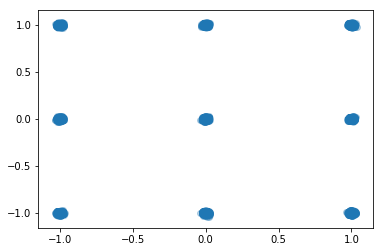

In [49]:
samples = draw_true_samples(10000,'noise')

plt.figure()
if len(samples.shape)==1:
    plt.hist(samples, histtype='step')
elif len(samples.shape)==2:
    plt.scatter(samples[:,0], samples[:,1], marker='o', alpha=0.3)
plt.show()

In [5]:
LCDM = dict({'Om_b_h2':[0.02, 0.00014], 'Om_c_h2':[0.1188, 0.001], 't0':[13.799e9, 0.021e9], 'ns':[0.9667, 0.004], 'delta_r_2':[2.441e-9, 0.09e-9], 'tau':[0.066, 0.012]})

def sample_LCDM():
    params = []
    for key in LCDM:
        print key
        print LCDM[key][0], LCDM[key][1]
        params.append(np.random.normal(LCDM[key][0], LCDM[key][1]))
    
    print 'params'
    print params
sample_LCDM()

In [130]:
class Perceptron(torch.nn.Module):
    def __init__(self, sizes, final=None):
        super(Perceptron, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            if i != (len(sizes) - 2):
                layers.append(torch.nn.ReLU())
        if final is not None:
            layers.append(final())
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
   
    
def sample_noise(bs, d):
    z = torch.randn(bs, d).float()
    return Variable(z.to(Device), requires_grad=True)
    
def restore_nn(filepath):
    # get config parameters from run and use to construct Perceptron object
    filen = open(filepath+'/params.txt','r')
    pdict = pickle.load(filen)
    pdict['latent_dim'] = 2
    model = Perceptron([pdict['latent_dim']+pdict['n_cond_params']] + [pdict['n_hidden']] * pdict['n_layers'] + [pdict['n_out']])
    model.load_state_dict(torch.load(filepath+'/netG'))
    model.eval()
    
    return model, pdict

In [178]:
from scipy import stats

basedir = '/Users/richardfeder/Documents/caltech/gan_work/results/'
mutrue, stdtrue = 3.4, 0.5

def generate_samples(G, pdict, nsamp, cond_params=None):
    arr = np.zeros((nsamp, 2))
    for x in xrange(nsamp):
        gen_input = torch.from_numpy(np.random.normal(size=pdict['latent_dim'])).float()
        if cond_params is not None:
            gen_input = torch.cat((gen_input, torch.tensor(cond_params)), -1)
#         arr[x] = G(gen_input.float()).item()
#         print gen_input
#         print G(gen_input)
        arr[x] = G(gen_input).detach().numpy()
            
    return arr
#         gen_input = torch.cat((torch.from_numpy(np.random.normal(size=pdict['latent_dim'])), torch.tensor([mutrue, stdtrue]).double()), -1)

def make_comparison_plot(true, fake, ks=None, save=None):
    muf, stdf = np.mean(fake), np.std(fake)
    print muf, stdf
    
    plt.figure()
    if ks is not None:
        plt.title('KS Statistic D = '+ str(np.round(ks.statistic, 5)))
    _, bins, _ = plt.hist(true, histtype='step', label='True', bins=20)
    plt.hist(fake, histtype='step', bins=bins, label='Generated')
    plt.legend()
    if save is not None:
        plt.savefig(save+'.png', bbox_inches='tight')
    plt.show()
    

''' Kolmogorov-Smirnov Test on True vs. Generated Samples. This test only applies to 1D distributions. 

    Inputs: 
        gen_array (N,) -- an ndarray with samples from the generator
        cond_params (n_cond,) -- a list of length n_cond specifying conditional parameters of distribution denoted by samp_type
        samp_type -- a str specifying type of distribution to sample
        
    Output:
        ks -- an object with KS statistic and p-value (D, p)
'''
def ks_test(gen_array, cond_params, samp_type='norm'):
    if samp_type=='norm':
        ks = stats.ks_2samp(np.random.normal(cond_params[0], cond_params[1], 100000), arr)
#         ks = stats.kstest(arr, lambda x: stats.norm.cdf(x, loc=cond_params[0], scale=cond_params[1]))
#     print ks
    return ks

def kl_divergence(gen_array, cond_params, samp_type='norm'):
    if samp_type =='norm':
        true = np.random.normal(cond_params[0], cond_params[1], 10000)
    
    true_hist, bins = np.histogram(true, density=True)
    gen_hist, _ = np.histogram(gen_array, density=True, bins=bins)

    kl = stats.entropy(true_hist+1e-5, gen_hist+1e-5)
    return kl
        


def test_cGAN(timestr, cond_params=None, nsamp=10000):
    netG, pdict = restore_nn(basedir+timestr)
    print pdict
    if cond_params is None:
        cond_params = [mutrue, stdtrue]
    print 'Conditional parameters:', cond_params
    arr = generate_samples(netG, pdict, nsamp, cond_params=cond_params)
    ks = ks_test(arr, cond_params)
    kl = kl_divergence(arr, cond_params)
#     print 'KL Divergence:', kl
    real = np.random.normal(cond_params[0], cond_params[1], nsamp)
    frame_dir = basedir+timedir+'/frames/'+str(cond_params[0])+'_'+str(cond_params[1])
    make_comparison_plot(real, arr, ks=ks, save=frame_dir)
    

# test_cGAN('20190123-150922', cond_params=[1.5, 1.5])

pd9ct: {'latent_dim': 2, 'extraD': 10, 'verbosity': 0, 'n_layers': 3, 'conditional_gan': 1, 'batch_size': 256, 'n_iterations': 1000, 'loss_func': 'MSE', 'lr': 0.0002, 'b1': 0.5, 'b2': 0.999, 'n_cond_params': 2, 'n_cpu': 8, 'n_hidden': 512, 'n_out': 1, 'sample_type': '1d_gaussian'}
0.0546619371106 0.157923182654


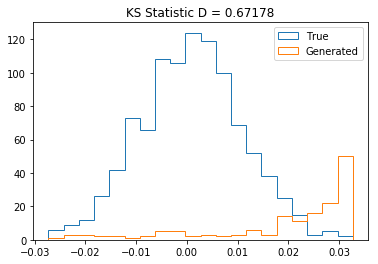

0.0725768681543 0.266816472812


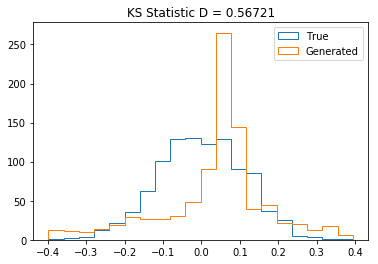

0.0706391193471 0.360793234024


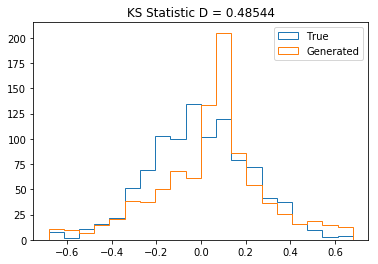

0.0267475492336 0.442717249123


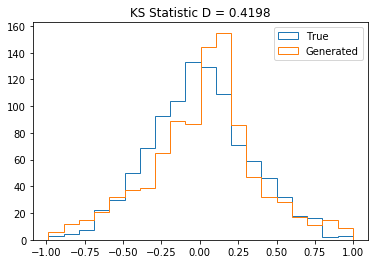

0.0303568357909 0.576638841417


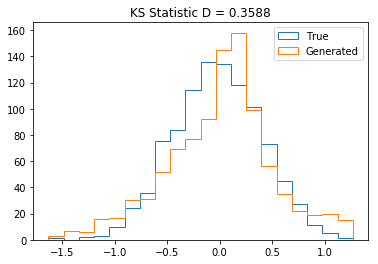

-0.0124241991938 0.65807813077


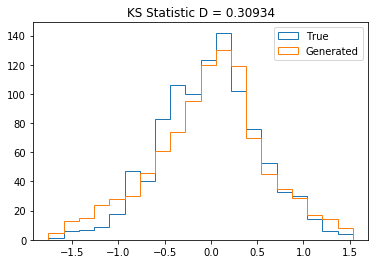

-0.0243553976202 0.810925754199


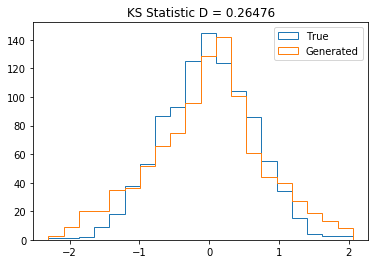

0.00832292067469 0.986052449105


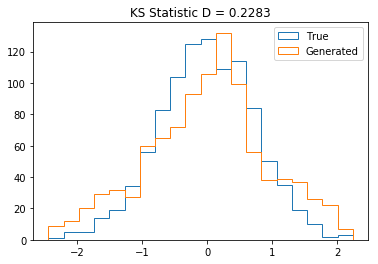

-0.0500054519897 1.04843425684


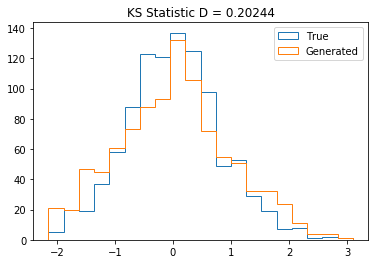

-0.164231515032 1.16100905684


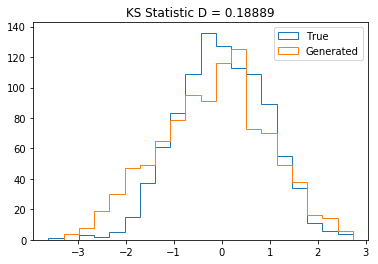

-0.0828977947197 1.29725404328


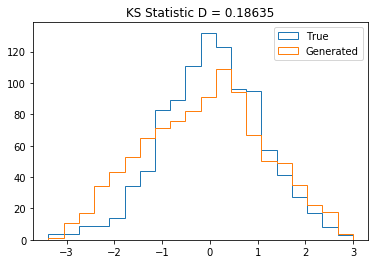

-0.105779133666 1.38146944061


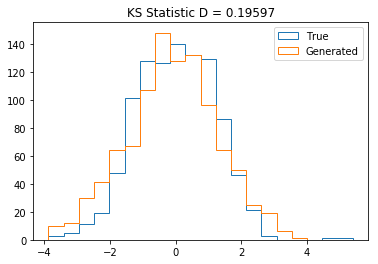

-0.0547485798221 1.45140127812


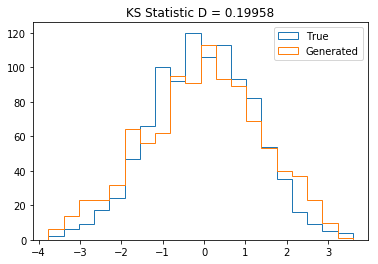

-0.155098684696 1.56893403705


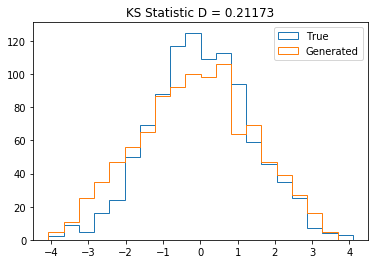

-0.181059313743 1.65265489417


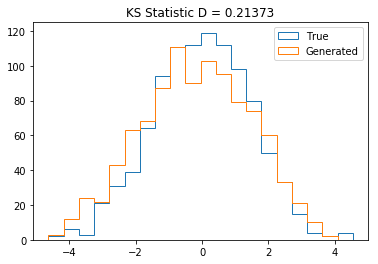

-0.209170350844 1.71494341584


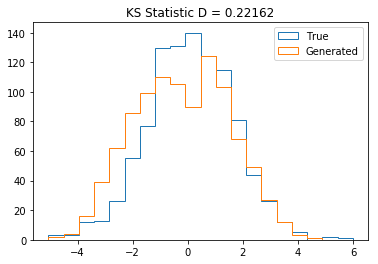

-0.226620816892 1.85518327557


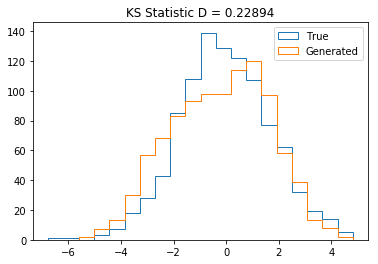

-0.210738403108 1.77677476998


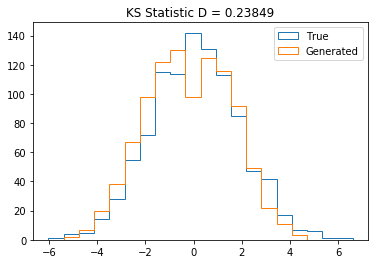

-0.0732640848774 1.95216379677


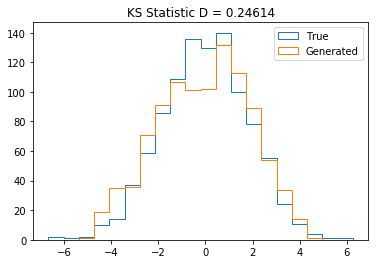

-0.173975602232 1.98575020006


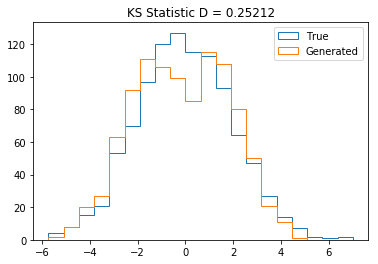

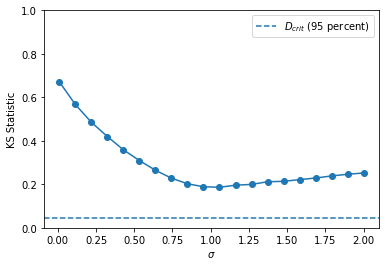

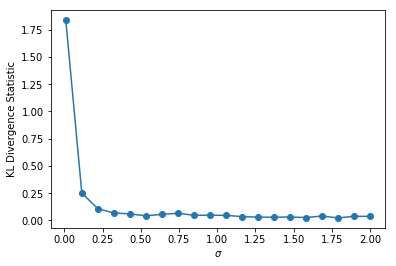

In [156]:
def ks_test_cGAN(timestr, vals, nsamp=1000, plot=True, save=False):
    netG, pdict = restore_nn(basedir+timestr)
    
    Ds = []
    ps = []
    KL = []
    mus, sigs = [], []
    for val in vals:
        cond_params = [0.0, val]
#         cond_params = [val, 1.0]
        arr = generate_samples(netG, pdict, nsamp, cond_params=cond_params)
        mus.append(np.mean(arr))
        sigs.append(np.std(arr))
        ks = ks_test(arr, cond_params)
        kl = kl_divergence(arr, cond_params)
        Ds.append(ks.statistic)
        ps.append(ks.pvalue)
        KL.append(kl)
        
        real = np.random.normal(cond_params[0], cond_params[1], arr.shape[0])
        frame_dir = basedir+timestr+'/frames/'+str(cond_params[0])+'_'+str(cond_params[1])
        make_comparison_plot(real, arr, ks=ks, save=frame_dir)
    
        
    if plot:
        plt.figure()
        plt.plot(vals, Ds, marker='o')
        plt.axhline(1.36/np.sqrt(1000), linestyle='dashed', label='$D_{crit}$ (95 percent)')
        plt.xlabel('$\sigma$')
#         plt.xlabel('$\mu$')
        plt.ylim(0, 1)
        plt.ylabel('KS Statistic')
        plt.legend()
        if save:
#             plt.savefig(basedir+timestr+'/kstest_mus.png', bbox_inches='tight')
            plt.savefig(basedir+timestr+'/kstest_sig_mu=0.0.png', bbox_inches='tight')
        plt.show()
        
        plt.figure()
        plt.plot(vals, KL, marker='o')
        plt.xlabel('$\sigma$')
#         plt.xlabel('$\mu$')
        plt.ylabel('KL Divergence Statistic')
        plt.legend()
        if save:
#             plt.savefig(basedir+timestr+'/KLDivTest_mus.png', bbox_inches='tight')
            plt.savefig(basedir+timestr+'/KLDivTest_sig_mu=0.0.png', bbox_inches='tight')
        plt.show()
        
#         plt.figure(figsize=(9, 4))
#         plt.subplot(1,2,1)
#         plt.plot(vals, vals, label='Truth')
#         plt.plot(vals, mus, label='Generated')
# #         plt.plot(vals, sigs, label='Generated')
#         plt.xlabel('$\mu$ used in conditioning')
#         plt.ylabel('$\mu$ estimated')
# #         plt.xlabel('$\sigma$ used in conditioning')
# #         plt.ylabel('$\sigma$ estimated')
#         plt.legend()
        
#         plt.subplot(1,2,2)
#         plt.axhline(1.0)
#         plt.plot(vals, sigs, label='Generated')
# #         plt.plot(vals, mus, label='Generated')
#         plt.ylabel('$\sigma$ estimated')
#         plt.xlabel('$\mu$ used in conditioning')
# #         plt.ylabel('$\mu$ estimated')
# #         plt.xlabel('$\sigma$ used in conditioning')
#         if save:
#             plt.savefig(basedir+timestr+'/fix_sig_change_mu.png', bbox_inches='tight')
# #             plt.savefig(basedir+timestr+'/fix_mu_change_sig_mu=0.5.png', bbox_inches='tight')

#         plt.show()

        
    return Ds, ps, KL
    
mus = np.linspace(-1, 1, 30)

sigs = np.linspace(0.01, 2, 20)

Ds, ps, KL = ks_test_cGAN('20190123-150922', sigs, save=True)


pd9ct: {'latent_dim': 2, 'extraD': 10, 'verbosity': 0, 'n_layers': 3, 'conditional_gan': 1, 'batch_size': 256, 'n_iterations': 1000, 'loss_func': 'MSE', 'lr': 0.0002, 'b1': 0.5, 'b2': 0.999, 'n_cond_params': 5, 'n_cpu': 8, 'n_hidden': 512, 'n_out': 2, 'sample_type': '2d_gaussian'}
(1000, 2)
-0.232162095083 -0.0504186367979 0.715195229773 0.579103332024 0.852947883236


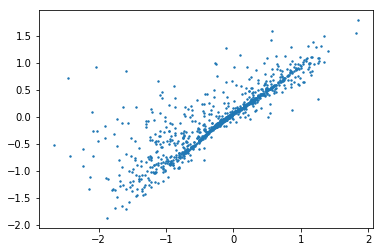

In [192]:
cond_params = [0.0, 0.0, 0.5, 0.5, 0.9]
nsamp = 1000
netG, pdict = restore_nn(basedir + '20190123-231122')
arr = generate_samples(netG, pdict, nsamp, cond_params=cond_params)
print arr.shape


print np.mean(arr[:,0]), np.mean(arr[:,1]), np.std(arr[:,0]), np.std(arr[:,1]), np.cov(arr[:,0], arr[:,1])[0,1]/(np.std(arr[:,0])*np.std(arr[:,1]))
plt.figure()
plt.scatter(arr[:,0], arr[:,1], s=2)
plt.show()